<a href="https://colab.research.google.com/github/arunjegathesh/MLNS_Link_Prediction/blob/node2vec_node_features_test/Link_prediction_graph_centrality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [2]:
pip uninstall gensim

Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/gensim-4.3.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/gensim/*
Proceed (Y/n)? Y
  Successfully uninstalled gensim-4.3.1


In [3]:
!pip install gensim #==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 57.0 MB/s eta 0:00:00


In [1]:
import gensim
print(gensim.__version__)

4.3.1


In [2]:
import os
import sys
import numpy as np 
import pandas as pd
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [5]:
def CreateGraph (X, y, directed = False):
    
    if directed:
        G = nx.from_pandas_edgelist(X, 'node', 'target', create_using=nx.DiGraph())
    else:    
        G = nx.from_pandas_edgelist(X[y == 1], 'node', 'target', create_using=nx.Graph())
        
    G.add_nodes_from(range(10496))
    
    return G

In [ ]:
#can skip node2vec part as it is still in testing phase

In [8]:
from sklearn.decomposition import PCA
from node2vec import Node2Vec

In [30]:
# Train the Node2Vec model to generate node embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, p=1, q=0.5, workers=4)

model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/10496 [00:00<?, ?it/s]

In [31]:
# Get the node embeddings as a dictionary
embeddings = model.wv

In [35]:
# Create a list to store the node embeddings
embeddings_list = []

# Iterate over each row in the dataframe and retrieve the node embeddings
for _, row in links.iterrows():
    node = row['node']
    target = row['target']
    embedding = embeddings[str(node)]
    embeddings_list.append(embedding)

In [38]:
# Convert the list of embeddings to a pandas dataframe and merge it with the original dataframe
embeddings_df = pd.DataFrame(embeddings_list, columns=['embedding_'+str(i) for i in range(64)])
node2vec_df = pd.concat([links, embeddings_df], axis=1)

In [6]:
def AppendNextworkxFeature (function, G, X):
    
    column_name = str(function).split()[1]
    
    tuple_list = list(X[['node','target']].itertuples(index=False, name=None))
    coef_generator = function(G, tuple_list)
    coef_df = pd.DataFrame(coef_generator)
    X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [7]:
def AppendNextworkxFeature_graphlevel (function, G, X):
    
    column_name = str(function).split()[1]
    
    coef_generator = function(G)
    X[column_name] = X['node'].map(coef_generator)

In [11]:
def nxGenerateFeatures(X_train, X_test, y_train):
    
    G = CreateGraph(X_train, y_train)

    # 1.3 Predict new coefficient/feature for defined link prediction function
    linkPredictionFunctions1 = [
        nx.resource_allocation_index,
        nx.jaccard_coefficient,
        nx.preferential_attachment]
    
    linkPredictionFunctions2 = [
        
        # nx.degree_centrality,
        #                         nx.betweenness_centrality,
        #                         nx.closeness_centrality,
        #                         nx.eigenvector_centrality,
                                nx.clustering,
                                #nx.pagerank,
                                nx.katz_centrality_numpy,
                                nx.average_neighbor_degree]
                                #nx.triangles]

    for function in linkPredictionFunctions1:
        AppendNextworkxFeature(function, G, X_train)
        AppendNextworkxFeature(function, G, X_test)
    
    for function in linkPredictionFunctions2:
        AppendNextworkxFeature_graphlevel(function, G, X_train)
        AppendNextworkxFeature_graphlevel(function, G, X_test)

    return G, X_train, X_test


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [12]:
G, X_train, X_test = nxGenerateFeatures (X_train, X_test, y_train)

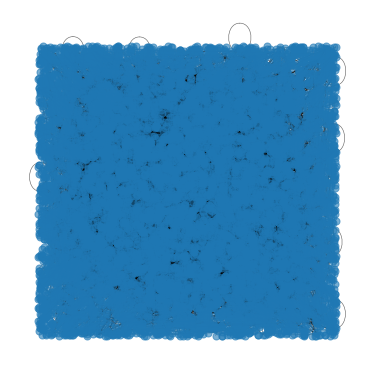

In [13]:
# Plot graph
plt.figure(figsize=(5,5))

pos = nx.random_layout(G, seed=19)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)

plt.show()

In [48]:
X_train

,node,target,preferential_attachment,jaccard_coefficient,resource_allocation_index,clustering,pagerank,katz_centrality_numpy,average_neighbor_degree,triangles
4619,4616,7205,10,0.0,0.0,0.0,0.000215,0.008998,3.000000,0
10414,2921,4098,2,0.0,0.0,0.0,0.000189,0.012144,10.500000,0
9819,2827,5655,3,0.0,0.0,0.0,0.000199,0.013873,5.000000,0
2157,3236,6799,21,0.0,0.0,0.0,0.000192,0.016952,10.000000,0
3846,2909,4571,3,0.0,0.0,0.0,0.000103,0.006404,4.000000,0
...,...,...,...,...,...,...,...,...,...,...
5734,2954,3004,2,0.0,0.0,0.0,0.000119,0.007877,2.000000,0
5191,800,5171,4,0.0,0.0,0.0,0.000101,-0.008127,299.000000,0
5390,609,2031,1,0.0,0.0,0.0,0.000098,0.009598,7.000000,0
860,2610,6516,6,0.0,0.0,0.0,0.000295,0.009932,2.666667,0


In [ ]:
# coef_df = pd.DataFrame(coef_generator)
#     X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [ ]:
# tuple_list = list(X_train[['node','target']].itertuples(index=False, name=None))
# coef_generator = nx.adamic_adar_index(G)

In [14]:
aa = nx.adamic_adar_index(G)

# create a dictionary to store the results
aa_dict = {}
for u, v, p in aa:
    aa_dict[(u, v)] = p

In [15]:
X_train['adamic_adar_index'] = X_train.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1)

In [16]:
X_test['adamic_adar_index'] = X_test.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1)

In [ ]:
X_train

,node,target,preferential_attachment,jaccard_coefficient,resource_allocation_index,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,clustering,pagerank,katz_centrality_numpy,average_neighbor_degree,triangles,adamic_adar_index
4619,4616,7205,10,0.0,0.0,0.000191,0.000058,0.038118,5.189791e-08,0.0,0.000215,0.008998,3.000000,0,0.0
10414,2921,4098,2,0.0,0.0,0.000191,0.000115,0.052175,3.493349e-05,0.0,0.000189,0.012144,10.500000,0,0.0
9819,2827,5655,3,0.0,0.0,0.000286,0.000007,0.051958,4.266455e-04,0.0,0.000199,0.013873,5.000000,0,0.0
2157,3236,6799,21,0.0,0.0,0.000286,0.000023,0.057994,2.918656e-03,0.0,0.000192,0.016952,10.000000,0,0.0
3846,2909,4571,3,0.0,0.0,0.000095,0.000000,0.053286,2.353392e-03,0.0,0.000103,0.006404,4.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2954,3004,2,0.0,0.0,0.000095,0.000000,0.038761,5.076600e-07,0.0,0.000119,0.007877,2.000000,0,0.0
5191,800,5171,4,0.0,0.0,0.000095,0.000000,0.064402,4.044902e-02,0.0,0.000101,-0.008127,299.000000,0,0.0
5390,609,2031,1,0.0,0.0,0.000095,0.000000,0.048885,5.397126e-05,0.0,0.000098,0.009598,7.000000,0,0.0
860,2610,6516,6,0.0,0.0,0.000286,0.000072,0.043479,1.818264e-05,0.0,0.000295,0.009932,2.666667,0,0.0


In [17]:
def XGB(LR = 0.0001, n_est = 10000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1, lambd = 0 , alpha = 0):
   
    xgb_model = XGBClassifier( learning_rate=LR,
                                            n_estimators=n_est,
                                            max_depth=max_d,
                                            min_child_weight=min_c,                         
                                            gamma=gm,
                                            colsample_bytree=colsample,
                                            subsample=subs,
                                            objective ='binary:logistic',                   
                                            reg_lambda=lambd,
                                            reg_alpha=alpha,
                                            scale_pos_weight = 1,
                                            tree_method='gpu_hist',
                                            seed=42)


    xgb_model.fit(X_train,y_train)
    y_pred_train = xgb_model.predict(X_train)
    y_pred = xgb_model.predict(X_test)


    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))

In [18]:
def XGB_tuning (LR = 0.1, n_est = 1000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1,
                lambd = 0, alpha = 0, param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate=LR, 
                                                    n_estimators=n_est,
                                                    max_depth=max_d,
                                                    min_child_weight=min_c,                         
                                                    gamma=gm,
                                                    colsample_bytree=colsample,
                                                    subsample = subs,
                                                    objective ='binary:logistic',
                                                    reg_lambda=lambd,
                                                    reg_alpha=alpha,
                                                    scale_pos_weight = 1,
                                                    tree_method='gpu_hist',
                                                    seed=42), 
                            param_grid = param_test, 
                            scoring='f1',
                            n_jobs=4, 
                            cv=3)


    gsearch.fit(X_train, y_train)
    return gsearch

In [19]:
# STEP 1 - First XGB - A little bit overfitted, but could improve more the training set
LearningRate = 0.0001
n_estimators = 10000

# Fix Learning Rate and n_estimators
XGB(LearningRate, n_estimators)

performance over the training set: 0.7984858606101091
performance over the test set: 0.48081440877055603

              precision    recall  f1-score   support

           0       0.56      0.77      0.65       783
           1       0.63      0.39      0.48       792

    accuracy                           0.58      1575
   macro avg       0.59      0.58      0.56      1575
weighted avg       0.59      0.58      0.56      1575



In [20]:
# STEP 2 - Tuning max_depth and min_child_weight

parameters_test = {
    'max_depth':range(3,9,2),
    'min_child_weight':range(1,7,2)
}

gsearch2 = XGB_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_max_depth, best_min_child_weight = gsearch2.best_params_['max_depth'], gsearch2.best_params_['min_child_weight']
print(f"{gsearch2.best_params_} CV_Score: {gsearch2.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, min_c= best_min_child_weight)

{'max_depth': 7, 'min_child_weight': 1} CV_Score: 0.8134457409336376
performance over the training set: 0.8494518615000543
performance over the test set: 0.4661893396976929

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       783
           1       0.63      0.37      0.47       792

    accuracy                           0.57      1575
   macro avg       0.59      0.58      0.56      1575
weighted avg       0.59      0.57      0.56      1575



In [21]:
# STEP 3 - Tuning Gamma 
parameters_test = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}

gsearch3 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, min_c= best_min_child_weight,
                      param_test=parameters_test)
best_gamma = gsearch3.best_params_['gamma']
print(f"{gsearch3.best_params_} CV_Score: {gsearch3.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight, gm = best_gamma)

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'gamma': 0.0} CV_Score: 0.8134457409336376
performance over the training set: 0.8494518615000543
performance over the test set: 0.4661893396976929

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       783
           1       0.63      0.37      0.47       792

    accuracy                           0.57      1575
   macro avg       0.59      0.58      0.56      1575
weighted avg       0.59      0.57      0.56      1575



In [22]:
# STEP 4 - Tuning colsample_bytree and subsaample
parameters_test = {
    'colsample_bytree':[i/10.0 for i in range(7,11)],
    'subsample':[i/10.0 for i in range(7,11)]
}

gsearch4 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                      gm = best_gamma, param_test=parameters_test)
best_colsample_bytree, best_subsample = gsearch4.best_params_['colsample_bytree'], gsearch4.best_params_['subsample']
print(f"{gsearch4.best_params_} CV_Score: {gsearch4.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, 
                       min_c = best_min_child_weight, gm = best_gamma,  colsample = best_colsample_bytree, 
                       subs = best_subsample)

{'colsample_bytree': 1.0, 'subsample': 0.8} CV_Score: 0.8244226225048242
performance over the training set: 0.8543167401354693
performance over the test set: 0.46862589356632245

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       783
           1       0.63      0.37      0.47       792

    accuracy                           0.58      1575
   macro avg       0.59      0.58      0.56      1575
weighted avg       0.59      0.58      0.56      1575



In [ ]:
# STEP 5 - Tuning Regularization Parameters
# Lambda L2 Regularization
# Alpha L1 Regularization

parameters_test = {
    'reg_lambda':[1e-2, 0.1, 0.5, 1, 2, 10],
    'reg_alpha':[1e-2, 0.1, 0.5, 1, 2, 10],
}

gsearch5 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, 
                       min_c = best_min_child_weight, gm = best_gamma,  colsample = best_colsample_bytree, 
                       subs = best_subsample, param_test=parameters_test)

best_reg_lambda, best_reg_alpha = gsearch5.best_params_['reg_lambda'], gsearch5.best_params_['reg_alpha']
print(f"{gsearch5.best_params_} CV_Score: {gsearch5.best_score_}")

In [ ]:
# Closer Look
parameters_test = {
    'reg_lambda':[best_reg_lambda*0.8, best_reg_lambda, best_reg_lambda*1.2, best_reg_lambda*1.5],
    'reg_alpha':[best_reg_alpha*0.8, best_reg_alpha, best_reg_alpha*1.2, best_reg_alpha*1.5]
}

gsearch5 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       param_test=parameters_test)

best_reg_lambda, best_red_alpha = gsearch5.best_params_['reg_lambda'], gsearch5.best_params_['reg_alpha']
print(f"{gsearch5.best_params_} CV_Score: {gsearch5.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha)

In [ ]:
 # STEP 6 - Reducing Learning Rate and Adding More Trees
n_estimators = 10000
parameters_test = {
    'learning_rate':[i/100.0 for i in range(1,10)]
}

gsearch6 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha, param_test=parameters_test)

LearningRate = gsearch6.best_params_['learning_rate']
print(f"{gsearch6.best_params_} CV_Score: {gsearch6.best_score_}")


# Final Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha)

In [25]:
xgb_model = XGBClassifier(learning_rate=0.0001, 
                                        n_estimators=10000,
                                        max_depth=3,
                                        min_child_weight=3,                         
                                        gamma=0.1,
                                        colsample_bytree=1.0,
                                        subsample=0.9,
                                        objective ='binary:logistic',                   
                                        reg_lambda=8,
                                        reg_alpha=8,
                                        scale_pos_weight = 1,
                                        tree_method='gpu_hist',
                                        seed=42)


xgb_model.fit(X_train,y_train)
y_pred_train = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)


print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
print(classification_report(y_test, y_pred))

performance over the training set: 0.7722590981918059
performance over the test set: 0.556547619047619

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       783
           1       0.68      0.47      0.56       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.61      1575
weighted avg       0.63      0.62      0.61      1575



In [7]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [8]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/test.txt', header = None, 
                    sep = ' ', names = ['node', 'target'])
X_test = links[['node', 'target']]

In [10]:
G, X, X_test = nxGenerateFeatures (X, X_test, y)

In [11]:
#G = CreateGraph(X,y)

In [12]:
aa = nx.adamic_adar_index(G)

# create a dictionary to store the results
aa_dict = {}
for u, v, p in aa:
    aa_dict[(u, v)] = p

In [13]:
X['adamic_adar_index'] = X.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1)

In [17]:
X_test_adar = X_test[['node','target']]

In [19]:
# Create graph where each node is connected to all of its target nodes
G = nx.Graph()
for node in X_test_adar['node'].unique():
    targets = list(X_test_adar[X_test_adar['node'] == node]['target'])
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            G.add_edge(t1, t2)



In [20]:
aa_dict = {(u, v): p for u, v, p in nx.adamic_adar_index(G)}

In [21]:
# Create a list of Adamic-Adar index values for each node pair in X_test
aa_values = [aa_dict.get((row['node'], row['target']), 0) for index, row in X_test_adar.iterrows()]



In [22]:
# Add Adamic-Adar index as a new column to the dataframe
X_test_adar['adamic_adar_index'] = aa_values


<ipython-input-22-e05c0ec8b543>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_adar['adamic_adar_index'] = aa_values


In [26]:
# Inner join on node and target columns
X_test = pd.merge(X_test, X_test_adar, on=['node', 'target'], how='inner')

In [41]:
xgb_model = XGBClassifier(learning_rate=0.001, 
                                        n_estimators=10000,
                                        max_depth=3,
                                        min_child_weight=3,                         
                                        gamma=0.1,
                                        colsample_bytree=1.0,
                                        subsample=0.9,
                                        objective ='binary:logistic',                   
                                        reg_lambda=5,
                                        reg_alpha=5,
                                        scale_pos_weight = 1,
                                        tree_method='gpu_hist',
                                        seed=42)


xgb_model.fit(X,y)
y_pred_train = xgb_model.predict(X)
y_pred = xgb_model.predict(X_test)


print('performance over the training set: ' + str(f1_score(y, y_pred_train)))
#print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
#print(classification_report(y, y_pred))

performance over the training set: 0.7967559116669923


In [ ]:
# pd.DataFrame(y_pred, columns = ['predicted']).to_csv(result_file_name, sep=',', index=True, index_label='id')

In [42]:
df_out = pd.DataFrame(y_pred, columns = ['Predicted'])

In [43]:
df_out = df_out.reset_index()
df_out = df_out.rename(columns={'index': 'ID'})

In [31]:
df_out

,ID,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
3493,3493,1
3494,3494,0
3495,3495,1
3496,3496,0


In [44]:
df_out.to_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/final_test_results_20230325_v3.csv', index=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
G, X_train, X_test = nxGenerateFeatures (X_train, X_test, y_train)

In [ ]:
aa = nx.adamic_adar_index(G)

# create a dictionary to store the results
aa_dict = {}
for u, v, p in aa:
    aa_dict[(u, v)] = p

In [ ]:
X_train['adamic_adar_index'] = X_train.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1)

X_test['adamic_adar_index'] = X_test.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1)

In [81]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:

def CatBoost(LR = 0.0001, n_est = 10000, max_d = 5, l2_val = 0.1, subs = 1, early = 10,
             bt = 1):
   
    cb_model = CatBoostClassifier(learning_rate=LR,
                                   n_estimators=n_est,
                                   max_depth=max_d,
                                   reg_lambda=l2_val,
                                   subsample=subs,
                                  early_stopping_rounds= early,
                                  bagging_temperature = bt,
                                   random_state=42)

    cb_model.fit(X_train,y_train, verbose=False)
    y_pred_train = cb_model.predict(X_train)
    y_pred = cb_model.predict(X_test)

    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))


In [ ]:
def CatBoost_tuning (LR = 0.1, n_est = 1000, max_d = 5, lambd = 0.1, subs = 0.8, 
                     param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = CatBoostClassifier(learning_rate=LR,
                                                          n_estimators=n_est,
                                                          max_depth=max_d,
                                                          reg_lambda=lambd,
                                                          subsample=subs,
                                                          random_state=42), 
                            param_grid = param_test, 
                            scoring='f1',
                            n_jobs=4, 
                            cv=3)

    gsearch.fit(X_train, y_train, verbose = False)
    return gsearch


In [ ]:
# STEP 1 - First XGB - A little bit overfitted, but could improve more the training set
LearningRate = 0.0001
n_estimators = 1000

# Fix Learning Rate and n_estimators
CatBoost(LearningRate, n_estimators)

performance over the training set: 0.748204826368452
performance over the test set: 0.5569044006069803

              precision    recall  f1-score   support

           0       0.59      0.80      0.68       783
           1       0.70      0.46      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 2 - Tuning max_depth

parameters_test = {
    'max_depth':[3,5,7,9]
}

gsearch2_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_max_depth = gsearch2_cb.best_params_['max_depth']
print(f"{gsearch2_cb.best_params_} CV_Score: {gsearch2_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth)

{'max_depth': 9} CV_Score: 0.748854879562472
performance over the training set: 0.7494712103407756
performance over the test set: 0.5575757575757576

              precision    recall  f1-score   support

           0       0.60      0.80      0.68       783
           1       0.70      0.46      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 3 - l2_leaf tuning

parameters_test = {
    'l2_leaf_reg':[0.1, 1, 5, 10, 20]
}

gsearch3_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_l2_leaf= gsearch3_cb.best_params_['l2_leaf_reg']
print(f"{gsearch3_cb.best_params_} CV_Score: {gsearch3_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, l2_leaf_reg = best_l2_leaf)

In [ ]:
# STEP 4 - sub_sample tuning

parameters_test = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gsearch4_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_subsample= gsearch4_cb.best_params_['subsample']
print(f"{gsearch4_cb.best_params_} CV_Score: {gsearch4_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth,  subs = best_subsample)

{'subsample': 0.7} CV_Score: 0.7478623539302749
performance over the training set: 0.7494712103407756
performance over the test set: 0.5575757575757576

              precision    recall  f1-score   support

           0       0.60      0.80      0.68       783
           1       0.70      0.46      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 5 - lambda tuning

parameters_test = {'reg_lambda': [0.01, 0.1, 1, 10,100]}

gsearch5_cb = CatBoost_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_reglambda= gsearch5_cb.best_params_['reg_lambda']
print(f"{gsearch5_cb.best_params_} CV_Score: {gsearch5_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth,
        subs = best_subsample, l2_val = best_reglambda)

{'reg_lambda': 0.01} CV_Score: 0.7479693398271213
performance over the training set: 0.7503240249793803
performance over the test set: 0.5595147839272177

              precision    recall  f1-score   support

           0       0.60      0.80      0.68       783
           1       0.70      0.47      0.56       792

    accuracy                           0.63      1575
   macro avg       0.65      0.63      0.62      1575
weighted avg       0.65      0.63      0.62      1575



In [ ]:
# STEP 6 - LR tuning

parameters_test = {'learning_rate': [0.001, 0.01, 0.1, 1]}

gsearch6_cb = CatBoost_tuning (n_est = n_estimators, param_test=parameters_test)
best_lr= gsearch6_cb.best_params_['learning_rate']
print(f"{gsearch6_cb.best_params_} CV_Score: {gsearch6_cb.best_score_}")

# Evaluation
CatBoost(LR = best_lr, n_est = n_estimators, max_d=best_max_depth,
        subs = best_subsample, l2_val = best_reglambda)

{'learning_rate': 0.01} CV_Score: 0.7525625290022072
performance over the training set: 0.7750028772010589
performance over the test set: 0.5568685376661742

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       783
           1       0.67      0.48      0.56       792

    accuracy                           0.62      1575
   macro avg       0.63      0.62      0.61      1575
weighted avg       0.63      0.62      0.61      1575



In [ ]:
# STEP 7 - n_estimators tuning

parameters_test = {'n_estimators': [50, 100, 200, 500, 1000]}

gsearch7_cb = CatBoost_tuning (LR = LearningRate, param_test=parameters_test)
best_est= gsearch7_cb.best_params_['n_estimators']
print(f"{gsearch7_cb.best_params_} CV_Score: {gsearch7_cb.best_score_}")

# Evaluation
CatBoost(LR = best_lr, n_est = best_est, max_d=best_max_depth,
        subs = best_subsample, l2_val = best_reglambda)

{'n_estimators': 10000} CV_Score: 0.751004047842959
performance over the training set: 0.9973045822102427
performance over the test set: 0.5558739255014327

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       783
           1       0.64      0.49      0.56       792

    accuracy                           0.61      1575
   macro avg       0.61      0.61      0.60      1575
weighted avg       0.61      0.61      0.60      1575



In [ ]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/train.txt', header = None, 
                    sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [ ]:
links = pd.read_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/test.txt', header = None, 
                    sep = ' ', names = ['node', 'target'])
X_test = links[['node', 'target']]

In [ ]:
G, X, X_test = nxGenerateFeatures (X, X_test, y)

In [ ]:
aa = nx.adamic_adar_index(G)

# create a dictionary to store the results
aa_dict = {}
for u, v, p in aa:
    aa_dict[(u, v)] = p

In [ ]:
X['adamic_adar_index'] = X.apply(lambda row: aa_dict.get((row['node'], row['target']), 0), axis=1) 

In [ ]:
X_test_adar = X_test[['node','target']]

In [ ]:
# Create graph where each node is connected to all of its target nodes
G = nx.Graph()
for node in X_test_adar['node'].unique():
    targets = list(X_test_adar[X_test_adar['node'] == node]['target'])
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            G.add_edge(t1, t2)


In [ ]:
aa_dict = {(u, v): p for u, v, p in nx.adamic_adar_index(G)}


# Create a list of Adamic-Adar index values for each node pair in X_test
aa_values = [aa_dict.get((row['node'], row['target']), 0) for index, row in X_test_adar.iterrows()]


In [ ]:
# Add Adamic-Adar index as a new column to the dataframe
X_test_adar['adamic_adar_index'] = aa_values

# Inner join on node and target columns
X_test = pd.merge(X_test, X_test_adar, on=['node', 'target'], how='inner')

In [ ]:
cb_model = CatBoostClassifier(learning_rate=0.00001,
                              n_estimators=500,
                              max_depth=3,
                              reg_lambda=10,
                              subsample=1,
                              #early_stopping_rounds = 20,
                              #bagging_temperature = 0.1,
                              #random_strength = 10,
                              random_state=42)

cb_model.fit(X,y, verbose=False)
y_pred_train = cb_model.predict(X)
y_pred = cb_model.predict(X_test)

print('performance over the training set: ' + str(f1_score(y, y_pred_train)))
    # print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    # print(classification_report(y_test, y_pred))

performance over the training set: 0.7339750153594101


In [ ]:
df_out = pd.DataFrame(y_pred, columns = ['Predicted'])

In [ ]:
df_out = df_out.reset_index()
df_out = df_out.rename(columns={'index': 'ID'})

In [ ]:
df_out.to_csv('/content/drive/Shareddrives/MNLS/Kaggle/Data/final_test_results_20230322_v6.csv', index=False)